In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

### Step 1: Get climate data from ECAD
go to www.ecad.eu
go to "Daily data"
click on "Custom query (ASCII)"
set fields as in the table:
field	value
Type of series	blend
Country	your country
Location	your city or area
Element	Mean temperature
click on "Next"
click on "Download" and download the data
Important: The ECAD data is made available for public use. However, do not redistribute the raw data (on your GitHub profile or elsewhere)

### Step 2: Read the data into a DataFrame
Reading the ECAD data into pandas is a bit trickier than a standard CSV file. You will need to inspect the file in a text editor (not Excel). Pay attention to the following:

what is the column separator?
are there any headers?
how many lines contain comments before the real data starts?
Look up the parameters of pd.read_csv(). They are sufficient to read the file.

First 20 rows are introduction text and need to be skipped with 'skiprows'

In [2]:
df = pd.read_csv('/Users/melvinrinkleff/dev/code/22_fall_data_science/ECA_blended_custom/TG_STAID002759.txt',
              names=['SOUID', 'DATE', 'TG', 'Q_TG'], skiprows=20)

In [3]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


### Step 3: Data Wrangling
The TG column contains the temperature measured in 0.1 Celsius degrees. This was probably established decades ago when disk space and memory were more expensive (integers take less space).

Create a new column by dividing the temperature by 10.
Plot the raw temperature data as a line plot.

In [4]:
df['Temperature'] = df.apply(lambda row: row.TG/10, axis=1)

In [5]:
df.head()

,SOUID,DATE,TG,Q_TG,Temperature
0,127488,18760101,22,0,2.2
1,127488,18760102,25,0,2.5
2,127488,18760103,3,0,0.3
3,127488,18760104,-58,0,-5.8
4,127488,18760105,-98,0,-9.8


<AxesSubplot:xlabel='DATE'>

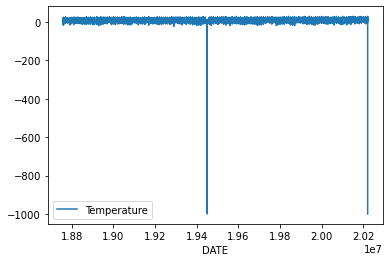

In [6]:
df.plot('DATE', 'Temperature')

### Step 4: Time Axis
The DATE column contains timestamps in the YYYYMMDD format. You need to convert these to pandas timestamps.

First, convert the DATE column to a string data type.

Second, use the following expression to slice off year, month and day:

df['year'] = df[col].str[x:y]
Put the elements into separate columns. Then, create a new date column via string concatenation:

df[col1] + '-' + df[col2]
The final date column should have the format YYYY-MM-DD. Now you can convert the strings with dates into a timestamp index with:

df.set_index(pd.to_datetime(date_series))
Plot the temperature as a line plot again. Now, the x-axis should look much better.

In [7]:
df['DATE'] = df['DATE'].astype(str)

In [8]:
df['year'] = df['DATE'].str[0:4]
df['month'] = df['DATE'].str[4:6]
df['day'] = df['DATE'].str[6:]

In [9]:
df.head()

,SOUID,DATE,TG,Q_TG,Temperature,year,month,day
0,127488,18760101,22,0,2.2,1876,01,01
1,127488,18760102,25,0,2.5,1876,01,02
2,127488,18760103,3,0,0.3,1876,01,03
3,127488,18760104,-58,0,-5.8,1876,01,04
4,127488,18760105,-98,0,-9.8,1876,01,05


In [10]:
df['Date'] = df['year'] + '-' + df['month'] + '-' + df['day']

In [11]:
df.head()

,SOUID,DATE,TG,Q_TG,Temperature,year,month,day,Date
0,127488,18760101,22,0,2.2,1876,01,01,1876-01-01
1,127488,18760102,25,0,2.5,1876,01,02,1876-01-02
2,127488,18760103,3,0,0.3,1876,01,03,1876-01-03
3,127488,18760104,-58,0,-5.8,1876,01,04,1876-01-04
4,127488,18760105,-98,0,-9.8,1876,01,05,1876-01-05


In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df = df.set_index('Date', drop=True)

In [14]:
df.head()

,SOUID,DATE,TG,Q_TG,Temperature,year,month,day
Date,,,,,,,,
1876-01-01,127488,18760101,22,0,2.2,1876,01,01
1876-01-02,127488,18760102,25,0,2.5,1876,01,02
1876-01-03,127488,18760103,3,0,0.3,1876,01,03
1876-01-04,127488,18760104,-58,0,-5.8,1876,01,04
1876-01-05,127488,18760105,-98,0,-9.8,1876,01,05


In [15]:
del df['TG']
del df['Q_TG']
del df['DATE']
del df['month']
del df['day']
del df['SOUID']

In [16]:
df.head()

,Temperature,year
Date,,
1876-01-01,2.2,1876
1876-01-02,2.5,1876
1876-01-03,0.3,1876
1876-01-04,-5.8,1876
1876-01-05,-9.8,1876


<AxesSubplot:xlabel='Date'>

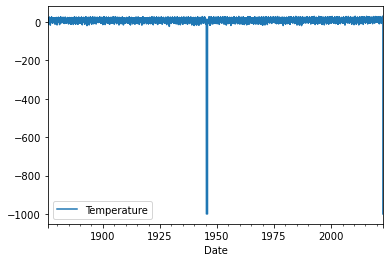

In [17]:
df.plot(y='Temperature')

### Step 5: Missing Values
For some cities, the data may contain missing values. In the original files the value -9999 is used. This can be done with the replace() method:

df[col].replace(-999.9, new_value)  # after scaling
As a new value, use the overall median temperature. Place the result of the expression in a new column.

Hint:
Instead of the median, you could average over the year before and after the gap or take the mean of exactly the same day of the adjacent years.

In [18]:
df_mean = df['Temperature'].mean()
df['Temperature'] = df['Temperature'].replace(-999.9, df_mean)

<AxesSubplot:xlabel='Date'>

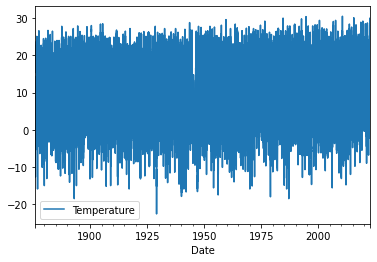

In [19]:
df.plot(y='Temperature')

### Step 6: Cut off the last year
Before calculating median temperatures, make sure the last year is complete as well. It can be cut off by slicing the index with a simple date string. Pandas takes care of the parsing:

df.loc[:'2021-12-31']

In [20]:
df2 = df.loc[:'2021-12-31']

### Step 7: Aggregate
Now reduce the data to one value per year using the median. This could be done with a df.groupby():

df.groupby('year')[col2].median()
However, with a timestamp index it is better to use df.resample():

yearly = df.resample(freq='Y').median()
The resampling has the advantage that you still have a timestamp index after the operation.

You may want to create a DataFrame out of the series:

df = pd.DataFrame(yearly)
Plot the aggregate as a line plot again.

Hint:
You may want to try out resampling different frequencies. pandas understands frequency values like '3M2d5h10sec'

See Offset Aliases for a list of all options in pandas.

In [21]:
yearly = df2.resample('Y').median()

In [22]:
df_yearly = pd.DataFrame(yearly)

<AxesSubplot:xlabel='Date'>

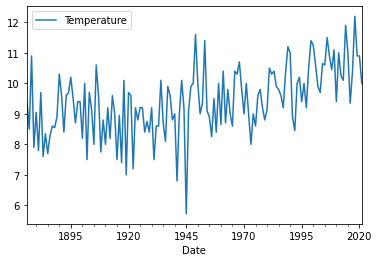

In [23]:
df_yearly.plot(y='Temperature')

### Step 8: Heatmap
The seaborn library has a heatmap function that you can use to plot the stripes.

cmap = plt.get_cmap('coolwarm')

plt.figure(figsize=(15, 5))
plt.title('yearly median temperature in Berlin-Dahlem')
sns.heatmap(df, cmap=cmap, cbar=False, yticklabels=[], xticklabels=[])
Save your stripe image to a file.

Hints:
make sure that your data is a single-column DataFrame
try df.transpose() if you want to have the stripes the other way
before plotting, setting the index to the year makes nicer tick labels.
if you put a typo in the name of the color map (coolwarm), matplotlib prints the available options
of course you could download multiple files and create a diagram with multiple rows of stripes

In [24]:
df3 = df.groupby('year')[['year', 'Temperature']].median().transpose()

<AxesSubplot:title={'center':'yearly median temperature in Berlin-Tempelhof'}, xlabel='year'>

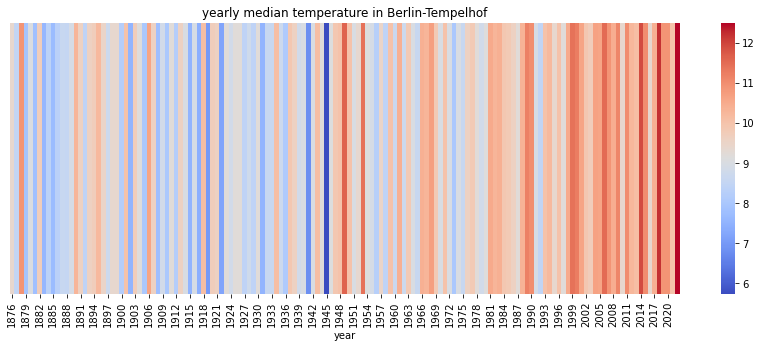

In [25]:
cmap = plt.get_cmap('coolwarm')

plt.figure(figsize=(15, 5))
plt.title('yearly median temperature in Berlin-Tempelhof')
sns.heatmap(df3, cmap=cmap, yticklabels=[])